In [134]:
import os
import time

import torch
from torch.utils.data import DataLoader
from torch import optim
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

In [150]:
class Config:    
    batch_size = 128
    
    img_width = 28
    img_height = 28
    img_channels = 1
    img_flattened_size = img_width * img_height * img_channels
    
    noise_dim = 128


In [151]:
torch.manual_seed(1661);

In [152]:
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root='../_DATASETS',
    download=True,
    train=True,
    transform=transforms,
)

train_loader = DataLoader(dataset=train_dataset, batch_size=Config.batch_size, shuffle=True)

tensor(0.) tensor(1.)


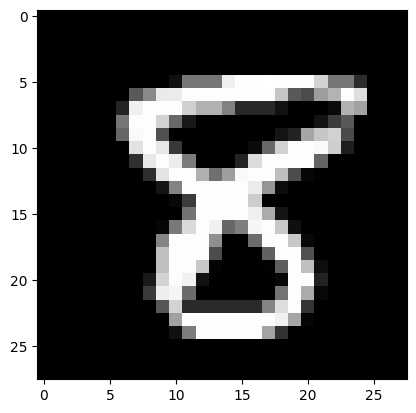

In [153]:
img, _ = train_dataset[3616]
img = (img + 1) / 2.0
print(img.min(), img.max())
plt.imshow(img.movedim(0,-1), cmap='gray');

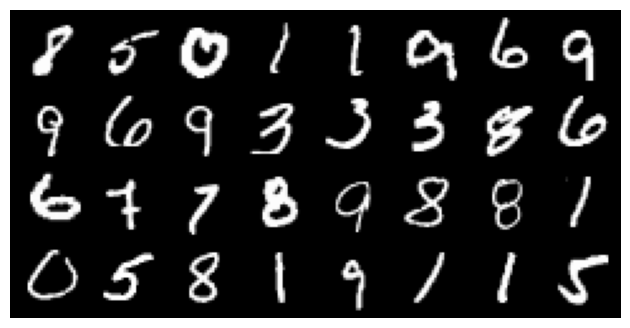

In [157]:
images, _ = next(iter(train_loader))
images = images[:32]

plt.figure(figsize=(8, 4))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(images, normalize=True)
            .movedim(0, -1))

In [140]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Linear(Config.noise_dim, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, Config.img_flattened_size),
            nn.Tanh()
        )

    def forward(self, x):
        # x has shape (B, Z_dim)

        # (B, C*W*H)
        flattened = self.blocks(x)

        # (B, C, W, H)
        img = flattened.view(
            flattened.shape[0], # Batch
            Config.img_channels,
            Config.img_width,
            Config.img_height,
        )

        return img

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Flatten(),
            nn.Linear(Config.img_flattened_size, 128),
            nn.LeakyReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x has shape (B, C, W, H)

        # (B, 1)
        logits = self.blocks(x)
        return logits

In [161]:
generator = Generator()
discriminator = Discriminator()

In [162]:
optim_g = optim.Adam(
    generator.parameters(),
    lr=0.0002
)

optim_d = optim.Adam(
    discriminator.parameters(),
    lr=0.0002
)

loss_fn = nn.BCEWithLogitsLoss()

In [131]:
generator.train()
discriminator.train()

for epoch in range(50):
    for real_images, _ in train_loader:
        batch_size = real_images.size(0)
        
        real_labels = torch.ones((batch_size, 1))
        fake_labels = torch.zeros((batch_size, 1))
        
        # ===============================
        # Train discriminator
        # ===============================
        optim_d.zero_grad()
        
        # Real images
        real_logits = discriminator(real_images)
        real_loss = loss_fn(real_logits, real_labels)
        
        # Fake images
        noise = torch.randn(batch_size, Config.noise_dim)
        fake_images = generator(noise)
        fake_logits = discriminator(fake_images.detach())
        fake_loss = loss_fn(fake_logits, fake_labels)
        
        # Total discriminator loss
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_d.step()
        
        # ===============================
        # Train generator
        # ===============================
        optim_g.zero_grad()
        
        # Generate fake images
        fake_logits = discriminator(fake_images)
        g_loss = loss_fn(fake_logits, real_labels)
        g_loss.backward()
        optim_g.step()

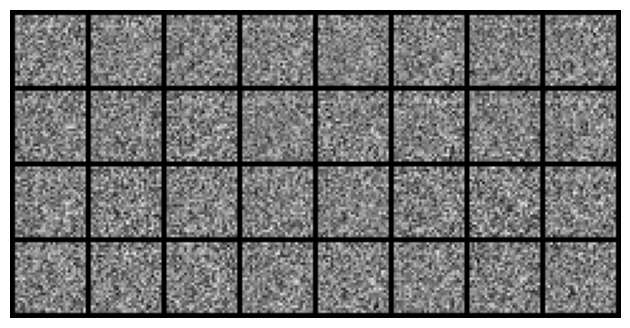

In [163]:
vis_noise = torch.randn(32, Config.noise_dim)
generator.eval()
with torch.no_grad():
    generated_images = generator(vis_noise)
    generated_images = (generated_images + 1) / 2
    # print(generated_images.min(), generated_images.max())
    
plt.figure(figsize=(8, 4))
plt.axis('off')
plt.imshow(torchvision.utils.make_grid(generated_images, normalize=True)
            .movedim(0, -1))